# Logistic model example

In [48]:
# libraries
library(data.table)
library(haven)
library(ggplot2)
library(brms)
source("../src/utils.R")

# read data
dat = data.table(read_stata("../data/Ex_LA1850-2020_SES_FULL_Jan25-2021.dta"))
setnames(dat, names(dat), tolower(names(dat)))

ctrylabs = attr(dat$ctry, "labels")
lab_list = as.list(setNames(attr(ctrylabs, "names"), as.numeric(ctrylabs)))
levels = as.numeric(ctrylabs)
labs = attr(ctrylabs, "names")
dat[, ctryf := factor(ctry, labels = labs, level = levels)]


# male
dat = dat[sex == 1 & age == 0 & year >= 1900 & year < 2010]
# remove LE duplicates
dat[, N := 1:.N, .(ctry, year, ex)]
dat = dat[N == 1]
anyDuplicated(dat[, .(ctry, year, ex)])
nrow(dat)

# select estimates
dat[, N := 1:.N, .(ctry, year)]
dat[, lambda := 0][tseries2 == 1, lambda := 1]
dat = dat[lambda == 1]
dat[, N := .N, .(ctry, year)]
dat = dat[N == 1]
dat[, max_ex := max(ex)]
dat[, tle := ex / (1.05 * max(ex))]


[1] 0

[1] 5426

In [53]:
# logistic model
f = bf(tle ~ alpha / (1 + exp( beta + exp(log(C) * gdp_pc))), 
         alpha ~ 1 + (1|ID1|year), 
         beta ~ 1, 
         C ~ 1, nl = TRUE)

priors = c(prior(normal(5.4, 0.1), nlpar='beta'),
            prior(uniform(0.5,1), lb=0.5, ub=1, nlpar='C'), 
            prior(normal(201.8, 0.1), nlpar='alpha'))

In [54]:
preston = brm(f, data = dat, prior = priors, 
    iter = 5000,
    chains = 2)

Warning message:
"Rows containing NAs were excluded from the model."
Compiling Stan program...

recompiling to avoid crashing R session

Start sampling




SAMPLING FOR MODEL 'f44f228ad3a0c5f9280fa8e824aad406' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.000995 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 9.95 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 5000 [  0%]  (Warmup)
Chain 1: Iteration:  500 / 5000 [ 10%]  (Warmup)
Chain 1: Iteration: 1000 / 5000 [ 20%]  (Warmup)
Chain 1: Iteration: 1500 / 5000 [ 30%]  (Warmup)
Chain 1: Iteration: 2000 / 5000 [ 40%]  (Warmup)
Chain 1: Iteration: 2500 / 5000 [ 50%]  (Warmup)
Chain 1: Iteration: 2501 / 5000 [ 50%]  (Sampling)
Chain 1: Iteration: 3000 / 5000 [ 60%]  (Sampling)
Chain 1: Iteration: 3500 / 5000 [ 70%]  (Sampling)
Chain 1: Iteration: 4000 / 5000 [ 80%]  (Sampling)
Chain 1: Iteration: 4500 / 5000 [ 90%]  (Sampling)
Chain 1: Iteration: 5000 / 5000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 155.953 seconds (Warm-up)
Chain 1:                410.096 seconds (Sampling)
C

Warning message:
"There were 7 transitions after warmup that exceeded the maximum treedepth. Increase max_treedepth above 10. See
http://mc-stan.org/misc/warnings.html#maximum-treedepth-exceeded"
Warning message:
"Examine the pairs() plot to diagnose sampling problems
"


In [ ]:
summary(preston)

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: tle ~ alpha/(1 + exp(beta + exp(log(C) * gdp_pc))) 
         alpha ~ 1 + (1 | ID1 | year)
         beta ~ 1
         C ~ 1
   Data: dat (Number of observations: 1744) 
Samples: 2 chains, each with iter = 5000; warmup = 2500; thin = 1;
         total post-warmup samples = 5000

Group-Level Effects: 
~year (Number of levels: 110) 
                    Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(alpha_Intercept)    40.19      2.87    35.04    46.42 1.00      420      565

Population-Level Effects: 
                Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
alpha_Intercept   201.80      0.10   201.60   202.00 1.00     5768     3412
beta_Intercept      5.68      0.02     5.64     5.72 1.01      241      451
C_Intercept         1.00      0.00     1.00     1.00 1.00     5324     4299

Family Specific Parameters: 
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sigma     0

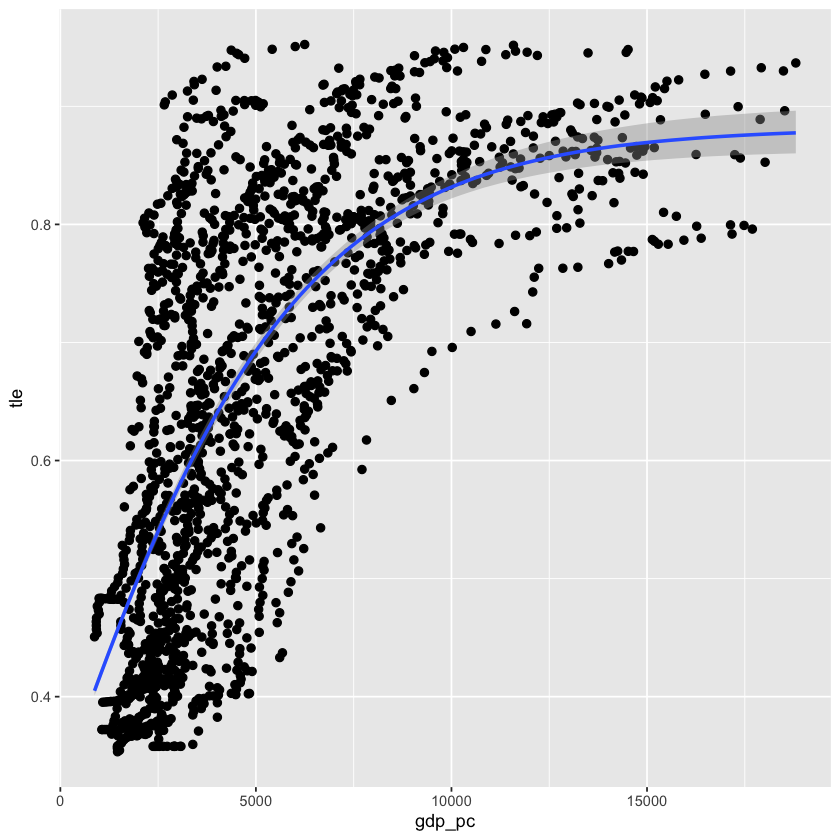

In [52]:
plot(conditional_effects(preston), points = TRUE)

In [24]:
m1 = brm(bf(ex ~ t2(gdp_pc) + (1 + gdp_pc |year)),
          data = dat, family = gaussian(), cores = 2, seed = 17,
          iter = 4000, warmup = 1000, thin = 10, refresh = 0,
          control = list(adapt_delta = 0.99))

Warning message:
"Rows containing NAs were excluded from the model."
Compiling Stan program...

Start sampling



In [25]:
summary(m1)

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: ex ~ t2(gdp_pc) + (1 + gdp_pc | year) 
   Data: dat (Number of observations: 1748) 
Samples: 4 chains, each with iter = 4000; warmup = 1000; thin = 10;
         total post-warmup samples = 1200

Smooth Terms: 
                Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sds(t2gdp_pc_1)    30.25     13.50    13.51    63.06 1.00     1209     1162

Group-Level Effects: 
~year (Number of levels: 110) 
                      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS
sd(Intercept)            13.99      1.06    12.02    16.22 1.00      884
sd(gdp_pc)                0.00      0.00     0.00     0.00 1.00     1040
cor(Intercept,gdp_pc)    -0.99      0.00    -1.00    -0.98 1.00      897
                      Tail_ESS
sd(Intercept)             1133
sd(gdp_pc)                1133
cor(Intercept,gdp_pc)      985

Population-Level Effects: 
           Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS

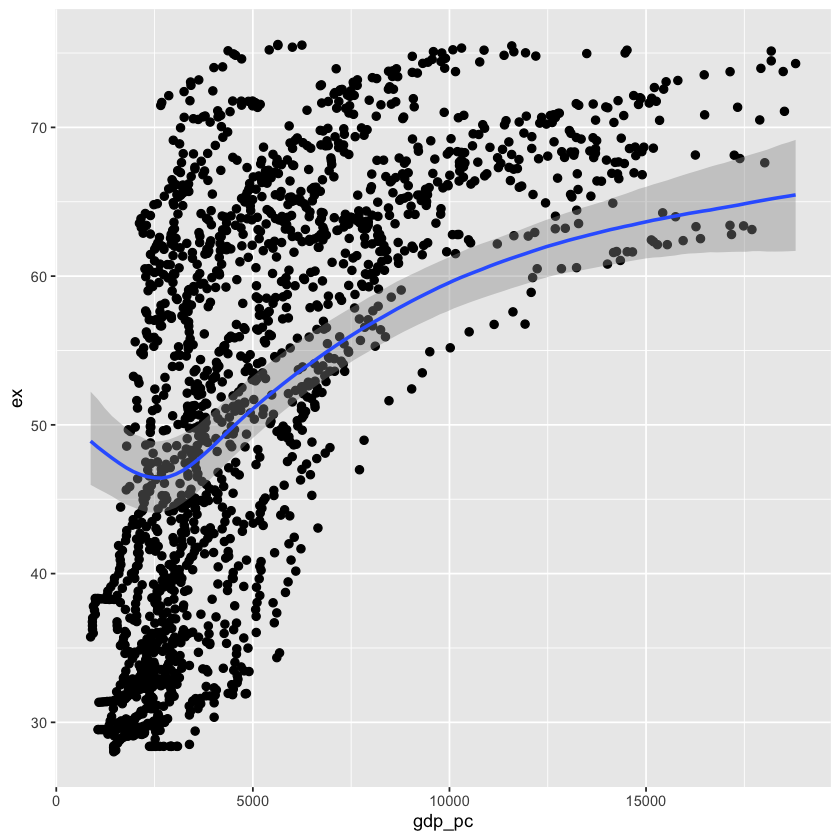

In [26]:
plot(conditional_effects(m1), points = TRUE, ask = FALSE)